
## Aperturas de ajedrez

En ajedrez existen multitud de aperturas y variantes. Te permiten planificar como posicionarás tus piezas, lo cual puede otorgar una gran ventaja durante el desarrollo de la partida. Hay muchas aperturas distintas. Como en cada apertura diferente podemos encontrar patrones parecidos, queremos realizar un análisis para clasificar  aperturas parecidas.

Partiremos de un [dataset de partidas de ajedrez](https://www.kaggle.com/datasets/datasnaek/chess) en la plataforma [lichess](https://lichess.org/), que consta de los siguientes campos (se resaltan los útiles para el análisis):

   - Game ID
   - Rated (T/F)
   - Start Time
   - End Time
   - **Number of Turns**
   - Game Status
   - Winner
   - Time Increment
   - White Player ID
   - White Player Rating
   - Black Player ID
   - Black Player Rating
   - **All Moves in Standard Chess Notation**
   - Opening Eco (código estandar de aperturas)
   - **Opening Name**
   - **Opening Ply** (número de movimientos de la apertura de la partida)


In [5]:
pip install plotly

  Using cached plotly-5.10.0-py2.py3-none-any.whl (15.2 MB)
  Using cached tenacity-8.1.0-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import random

import tqdm
import umap
import numpy as np
import pandas as pd
import sklearn
import scipy
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.

# Algoritmos de reduccion de dimensionalidad.
from sklearn import decomposition
from sklearn.metrics import pairwise_distances
import seaborn as sb
# from scipy import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MultiLabelBinarizer


# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline

Se carga el dataset en un dataframe de pandas:

In [7]:
df = pd.read_csv('games.csv')
print(len(df))
df.head()

20058


id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_eco  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00   
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20   
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02   
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41   

                             opening_name  opening_ply  
0        Slav Defense: Exchange Variation            5  
1  Nimzowitsch Defense: Kennedy Variation            4  
2   King's Pawn Game: Leonardis Variation            3  
3  Queen's Pawn Game: Zukertort Variation            3  
4                        Philidor Defense            5

Seleccionamos las partidas que tienen aperturas de 4 o más movimientos, y que tengan el doble de movimientos que los de la apertura (para descartar partidas fuera de lo común).


In [8]:
# filtramos las lineas que tienen el atributo openin_ply mayor o igual a 4
df = df[df['opening_ply'] >= 4]

# selccionamos las partidas que tienen como mínimo el doble de movimientos que su apertura
df = df[df['turns'] >= 2*df['opening_ply']]



Limpiamos el nombre de las apertura 



In [9]:
# si el nombre de la apertura (campo opening_name) contiene el caracter "|" ignoramos todo el texto que le sigue.
df['opening_name'] = df['opening_name'].str.split('|', expand=True)[0]
print(len(df))

# Eliminamos los espacios en blanco finales de los nombres
df['opening_name'] = df['opening_name'].str.strip()

12272


Nos quedamos sólo con las aperturas  que hayan sido usadas en al menos 40 partidas, para tener un mínimo de muestras de ese tipo, eliminando muchas aperturas apenas usadas.


In [10]:
count = df.groupby(['opening_name']).count()
listaAperturas = list(count[count['opening_eco'] >= 40].index)

# nos quedamos con las filas del df si el campo opening name
# esta en la lista de las aperturas
df = df[df['opening_name'].isin(listaAperturas)]


Los movimientos en ajedrez se pueden transcribir de distintas maneras, la más popular es la [notación algebraica](https://es.wikipedia.org/wiki/Notaci%C3%B3n_algebraica). En este caso, la notación algebraica empleada es la inglesa.

En concreto, el campo **moves** tiene los movimientos alternos tanto de las blancas como de las negras. Por tanto, la secuencia ```e4 c5 Nf3 Qa5...``` es:
 - blancas mueven el peón de rey a la casilla e4.
 - Las negras responden con el peón a c5.
 - Las blancas mueven el caballo (N) a la casilla f3.
 - Las negras mueven su dama a la casilla a5.
 
Y así alternan movimientos hasta el final de la partida (victoria, tablas, abandono o quedarse sin tiempo).

El campo **moves** es de tipo *string*, por lo que dividimos el separador (espacio) para tener cada movimiento por separado. Útil para los siguientes pasos.

In [11]:
# por cada partida creamos una lista de los movimientos pares para las blancas
listaPartidasBlancas = []
for partida in df['moves']:

    # las blancas son las posiciones impares, pero en python se
    # empieza a contar las listas como 0 así que las blancas son
    # las pares, como el 0 evalua como falso, si es par, es decir
    # if not false añadimos a las blancas el movimiento
    blancas = [movimiento for index, movimiento
               in enumerate(partida.split(' ')) if not index % 2]
    listaPartidasBlancas.append(blancas)

# creamos la nueva columna
df['white_moves'] = listaPartidasBlancas

Para comparar las aperturas entre sí usaremos los movimientos empleados en ella sólo por parte del jugador blanco. Generando, a partir del campo **white_moves** un nuevo dataset con tantas dimensiones como posibles movimientos con un 1 si se ha realizado durante la apertura y un 0 si no se ha realizado.

creamos un nuevo dataframe usando el modelo [bag of words](https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras). a partir del campo white_moves.

In [12]:
mlb = MultiLabelBinarizer()

bagOfWords = pd.DataFrame(mlb.fit_transform(df['white_moves']),
                          columns=mlb.classes_, index=df.index)

### Reducción de dimensionalidad

La reducción de dimensionalidad puede llevarse a cabo con métodos como PCA, pero este método tiene la limitación de que sólo realiza proyecciones lineales. Por lo que otros métodos como [t-SNE](https://www.youtube.com/watch?v=NEaUSP4YerM) o [UMAP](https://www.youtube.com/watch?v=jth4kEvJ3P8) pueden ofrecer mejores resultados.

In [18]:
reducer = umap.UMAP()

In [17]:
reducer

array([[4.931976 , 3.630918 ],
       [2.9960785, 0.4770041],
       [4.347775 , 0.2360521],
       ...,
       [6.8137717, 5.7601643],
       [2.4220595, 3.5604682],
       [5.5219607, 3.7357488]], dtype=float32)

In [19]:
embedding = reducer.fit_transform(bagOfWords)
embedding.shape

(7044, 2)

In [20]:
embedding

array([[ 5.5631285 ,  4.9902806 ],
       [ 2.5822275 , -0.20232777],
       [ 3.7696688 , -0.28854147],
       ...,
       [ 6.2827015 ,  5.265373  ],
       [ 1.8769932 ,  3.0297155 ],
       [ 5.153269  ,  3.2890165 ]], dtype=float32)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza la reducción de dimensionalidad mediante un scatter plot de la librería plotly donde cada punto es una muestra con coordenadas obtenidas tras la reducción de dimensionalidad. De tal manera que al situarnos encima de cada muestra con el ratón (hovertext) nos indique el nombre de la apertura usada, para poder explorar mejor los datos.
</div>

In [21]:
fig = go.Figure(data=go.Scatter(x=embedding[:, 0],
                                y=embedding[:, 1],
                                mode='markers',
                                text=df['opening_name']))

fig.update_layout(title='''Reducción a dos dimensiones
de las aperturas más usadas en ajedrez''')

fig.show()

###  Clustering

- Debido a la distribución de los datos, bastante compactos en forma de nuve, los algoritmos particionales basados en centroides (k-means y derivados) deberían funcionar mejor que los jerárquicos o los basados en densidad o proximidad de los vecinos.

In [22]:
def aplicaKmeans(datos, particiones):
    '''Esta funión nos devuelve la suma de los erroes cuadrados,
       que es la distancia de cada
       punto de la particiñon a su centroide asignado. Parámetros:
       1. Los datos para aplicar el algoritmo.
       2. El número de particiones a aplicar'''
    modelo = sklearn.cluster.KMeans(n_clusters=particiones)
    modelo.fit(datos)
    return modelo.inertia_

In [23]:
def elbowTest(datos):
    '''Esta función crea la visualización de los  suma de los errores
       cuadráticos (SSE) (que consiste en la suma de todos los errores
       (distancia de cada punto a su centroide asignado) al cuadrado)
       por número de particiones'''
    # Para diferentes valores de particiones guardamos los errores cuadrados
    errores = []
    valoresDeK = []

    for k in range(1, 11):
        errores.append(aplicaKmeans(datos=datos, particiones=k))
        valoresDeK.append(k)

    return plt.plot(valoresDeK, errores)

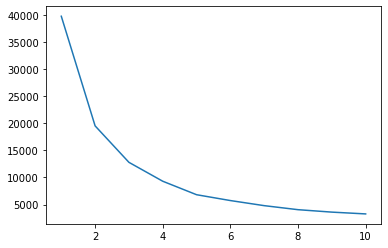

In [24]:
elbowTest(embedding)

Apreciamos gracias al elbow test que el numero ideal de clusters para las aberturas es de 3 o 5 grupos, preferiblemente 5 particiones.

visualizamos el anterior scatter plot con color para cada cluster asociado para poder observar el efecto de la calsificación. 

In [26]:
def representacionGruposPredichos(clusters, datos):
    '''Esta función crea la figura de los puntos del scatter con los clolres
       según los grupos predichos'''

    # creamos la representacion de los clusters
    plt.figure(figsize=(30, 15))

    # predecimos a que particion pertenence cada instancia
    prediccionesBlobs = cluster.KMeans(n_clusters=clusters).fit_predict(datos)

    # mostramos la visualización
    plt.subplot(221)
    plt.scatter(datos[:, 0], datos[:, 1],
                c=prediccionesBlobs, alpha=.3,
                cmap='jet')

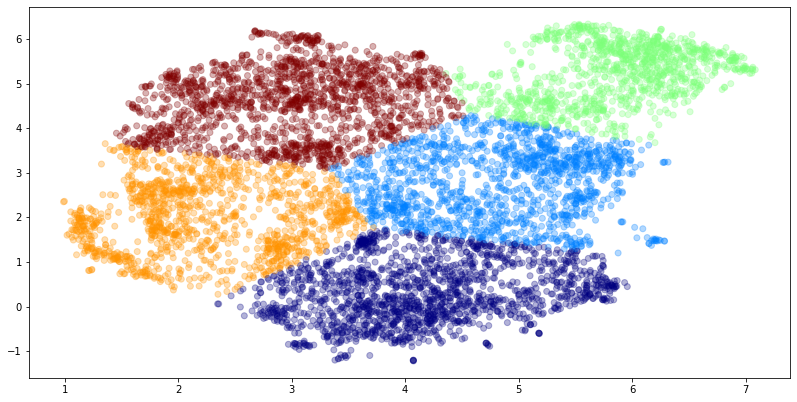

In [27]:
representacionGruposPredichos(clusters=5, datos=embedding)

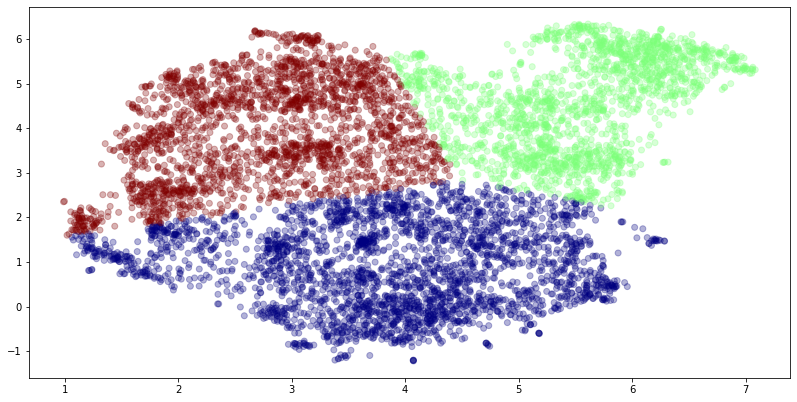

In [28]:
representacionGruposPredichos(clusters=3, datos=embedding)

Para cada cluster, visualizamos un gráfico de barras donde cada barra es una de las aperturas que aparecen en el cluster y su tamaño se corresponda con el número de muestras dentro de ese grupo que han realizado esa apertura. 

In [29]:
predicciones = cluster.KMeans(n_clusters=5).fit_predict(embedding)

In [30]:
aperturas = pd.DataFrame(predicciones, columns=['cluster'])
aperturas['apertura'] = list(df['opening_name'].values)
aperturas = aperturas.groupby('cluster')

In [31]:
import plotly.graph_objects as go
for i in range(5):
    openings = aperturas.get_group(i).apertura.values

    fig = go.Figure()

    histograma = px.histogram(y=openings, 
                              width=800,
                              height=1600)

    # configuramos las etiquetas de los ejes
    histograma.update_layout(
        yaxis_title=("aperturas grupo {}").format(i+1),
        xaxis_title="Frecuencia",
        yaxis={'categoryorder':'total descending'}
    )

    histograma.show()

### Análisis

Compararemos las aperturas empleando una matriz de distancias. Donde podemos representar cuál es la distancia mínima, media o máxima entre dos aperturas.

Dado que cada apertura tiene distintas muestras (al menos 40). Si usamos el mínimo y tuviésemos 5 muestras de la apertura A y 3 de la B. La distancia entre las aperturas A y B sería la mínima de las 15 distancias posibles que hay entre las 5 muestras de A y las 3 de B.


Calculamos y visualizamos la distancia euclídea entre todas las aperturas mediante una matriz de distancias usando plotly. 

In [54]:
aperturas = pd.DataFrame(list(embedding), columns=['X', 'Y'])

aperturas['nombre'] = list(df['opening_name'].values)

aperturas = aperturas.set_index('nombre')

In [55]:
aperturas

X         Y
nombre                                                           
Nimzowitsch Defense: Kennedy Variation         6.590628  3.645333
Philidor Defense                               1.702497 -0.051357
Italian Game: Schilling-Kostic Gambit          2.696852 -0.058202
Scandinavian Defense: Mieses-Kotroc Variation  5.779454  1.640005
French Defense: Advance Variation              2.918219  3.222713
...                                                 ...       ...
Sicilian Defense                               3.754616  4.556438
English Opening: King's English Variation      6.905180  3.530796
English Opening: King's English Variation      6.983889  3.580666
French Defense: Advance Variation #3           2.050756  3.240455
French Defense: Exchange Variation             5.337521  2.090264

[7044 rows x 2 columns]

In [56]:
# Cálculo de distancias
# ==============================================================================
print('------------------')
print('Distancia euclídea')
print('------------------')
distancias = pairwise_distances(
                X=aperturas,
                metric='euclidean'
             )

# Se descarta la diagonal superior de la matriz
distancias[np.triu_indices(n=distancias.shape[0])] = np.nan

distancias = pd.DataFrame(
                distancias,
                columns=aperturas.index,
                index=aperturas.index
            )

distancias.head(20)

------------------
Distancia euclídea
------------------


nombre                                         Nimzowitsch Defense: Kennedy Variation  \
nombre                                                                                  
Nimzowitsch Defense: Kennedy Variation                                            NaN   
Philidor Defense                                                             6.128567   
Italian Game: Schilling-Kostic Gambit                                        5.373794   
Scandinavian Defense: Mieses-Kotroc Variation                                2.163178   
French Defense: Advance Variation                                            3.696646   
Four Knights Game: Italian Variation                                         5.373350   
Italian Game: Two Knights Defense                                            4.882287   
Four Knights Game: Italian Variation                                         4.893493   
Four Knights Game: Italian Variation                                         3.508203   
Philidor Defense #3                                                          6.022108   
Italian Game: Anti-Fried Liver Defense                                       5.493398   
English Opening: King's English Variation                                    0.768978   
Queen's Pawn Game: Chigorin Variation                                        0.962114   
Queen's Pawn Game: Chigorin Variation                                        0.934602   
Queen's Gambit Refused: Marshall Defense                                     0.369614   
Robatsch (Modern) Defense                                                    2.089619   
Sicilian Defense: Dragon Variation                                           2.933329   
Sicilian Defense: Dragon Variation                                           4.041902   
Sicilian Defense: Dragon Variation                                           2.727192   
Sicilian Defense: Dragon Variation                                           3.397780   

nombre                                         Philidor Defense  \
nombre                                                            
Nimzowitsch Defense: Kennedy Variation                      NaN   
Philidor Defense                                            NaN   
Italian Game: Schilling-Kostic Gambit                  0.994378   
Scandinavian Defense: Mieses-Kotroc Variation          4.413874   
French Defense: Advance Variation                      3.492493   
Four Knights Game: Italian Variation                   1.814956   
Italian Game: Two Knights Defense                      2.535308   
Four Knights Game: Italian Variation                   3.142931   
Four Knights Game: Italian Variation                   2.967158   
Philidor Defense #3                                    0.557835   
Italian Game: Anti-Fried Liver Defense                 1.175097   
English Opening: King's English Variation              6.223055   
Queen's Pawn Game: Chigorin Variation                  6.955259   
Queen's Pawn Game: Chigorin Variation                  6.995075   
Queen's Gambit Refused: Marshall Defense               6.414945   
Robatsch (Modern) Defense                              4.329610   
Sicilian Defense: Dragon Variation                     6.006618   
Sicilian Defense: Dragon Variation                     4.861998   
Sicilian Defense: Dragon Variation                     5.916320   
Sicilian Defense: Dragon Variation                     5.654782   

nombre                                         Italian Game: Schilling-Kostic Gambit  \
nombre                                                                                 
Nimzowitsch Defense: Kennedy Variation                                           NaN   
Philidor Defense                                                                 NaN   
Italian Game: Schilling-Kostic Gambit                                            NaN   
Scandinavian Defense: Mieses-Kotroc Variation                               3.519424   
French Defense: Advance Variation     

In [57]:
# Distancias en filas
# ==============================================================================
minimas = distancias.melt(ignore_index=False, var_name="apertura_B",
                          value_name='distancia') \
    .rename_axis("apertura_A") \
    .reset_index() \
    .dropna()

In [58]:
# eliminamos las distancias hacia las mismas aperturas
minimas = minimas[minimas['apertura_A'] != minimas['apertura_B']]

In [59]:
# encontramos las distancias minimas, que coinciden
# con la primera fila del dataframe agrupado

listaAperturas = list(set(minimas['apertura_A']))
listaAperturas.sort()

posicionDistanciaMinima = []
aperturaX = []
aperturaY = []
distancias = []
for apertura in listaAperturas:
    B = minimas[minimas['apertura_A'] == apertura]

    for ind, aperturaB in enumerate(listaAperturas, 1):
        if apertura != listaAperturas[-ind]:
            AB = B[B['apertura_B'] == listaAperturas[-ind]].sort_values('distancia')
            aperturaX.append(apertura)
            aperturaY.append(listaAperturas[-ind])
            distancias.append(float(AB[:1].distancia))

        else:
            pass

In [60]:
print(len(posicionDistanciaMinima))
print(('''77*77 es 5929, menos 77(las distancias entre las mismas aperturas)
5929-77= {}Tenemos los indices de todas las distancias mínimas''')
      .format(5929-77))

0
77*77 es 5929, menos 77(las distancias entre las mismas aperturas)
5929-77= 5852Tenemos los indices de todas las distancias mínimas


In [61]:
distanciasMinimas = pd.DataFrame(aperturaX, columns=['Apertura A'])
distanciasMinimas['Apertura B'] = aperturaY
distanciasMinimas['Distancia'] = distancias

In [62]:
distanciasMinimas.head(15)

Apertura A  \
0   Bishop's Opening: Berlin Defense   
1   Bishop's Opening: Berlin Defense   
2   Bishop's Opening: Berlin Defense   
3   Bishop's Opening: Berlin Defense   
4   Bishop's Opening: Berlin Defense   
5   Bishop's Opening: Berlin Defense   
6   Bishop's Opening: Berlin Defense   
7   Bishop's Opening: Berlin Defense   
8   Bishop's Opening: Berlin Defense   
9   Bishop's Opening: Berlin Defense   
10  Bishop's Opening: Berlin Defense   
11  Bishop's Opening: Berlin Defense   
12  Bishop's Opening: Berlin Defense   
13  Bishop's Opening: Berlin Defense   
14  Bishop's Opening: Berlin Defense   

                                          Apertura B  Distancia  
0                              Three Knights Opening   0.041326  
1                                    Slav Defense #2   0.852340  
2                Sicilian Defense: Paulsen Variation   0.524201  
3                     Sicilian Defense: Old Sicilian   0.012432  
4   Sicilian Defense: Nyezhmetdinov-Rossolimo Attack   0.066798  
5                Sicilian Defense: Najdorf Variation   0.267829  
6                Sicilian Defense: Modern Variations   0.119405  
7                    Sicilian Defense: Kan Variation   0.755153  
8                 Sicilian Defense: French Variation   0.041691  
9                 Sicilian Defense: Dragon Variation   0.248136  
10                  Sicilian Defense: Delayed Alapin   0.044041  
11                Sicilian Defense: Closed Variation   0.052077  
12              Sicilian Defense: Accelerated Dragon   0.173896  
13                               Sicilian Defense #2   0.124370  
14                                  Sicilian Defense   0.013639

Encontramos que tenemos distancias de los mismos puntos diferentes, Ahora debemos de escoger la distancia minima de los pares.

In [64]:
listaAperturas = list(set(minimas['apertura_A']))
listaAperturas.sort()
listaAperturasB = list(set(minimas['apertura_A']))
listaAperturasB.sort()
listaAperturasB.reverse()
len(listaAperturasB)

77

In [65]:
AperturaA = []
AperturaB = []
DistanciaF = []

for apertura in listaAperturas:
    for ind, aperturaB in enumerate(listaAperturas, 1):
        if apertura == listaAperturas[-ind]:
            DistanciaF.append(0)
            AperturaB.append(listaAperturas[-ind])
            AperturaA.append(apertura)

        else:
            AB = float(distanciasMinimas[(distanciasMinimas['Apertura A'] == apertura) &
                                         (distanciasMinimas['Apertura B'] == listaAperturas[-ind])]['Distancia'])

            BA = float(distanciasMinimas[(distanciasMinimas['Apertura B'] == apertura) &
                                         (distanciasMinimas['Apertura A'] == listaAperturas[-ind])]['Distancia'])

            if AB > BA:
                DistanciaF.append(BA)
                AperturaB.append(listaAperturas[-ind])
                AperturaA.append(apertura)
            else:
                DistanciaF.append(AB)
                AperturaA.append(apertura)
                AperturaB.append(listaAperturas[-ind])

In [66]:
distanciasParesMinimas = pd.DataFrame(AperturaA, columns=['Apertura A'])
distanciasParesMinimas['Apertura B'] = AperturaB
distanciasParesMinimas['Distancias'] = DistanciaF

In [67]:
FINAL = distanciasParesMinimas.sort_values(by=['Apertura A', 'Apertura B'],
                                           ascending=[True, False])

In [68]:
FINAL

Apertura A  \
0     Bishop's Opening: Berlin Defense   
1     Bishop's Opening: Berlin Defense   
2     Bishop's Opening: Berlin Defense   
3     Bishop's Opening: Berlin Defense   
4     Bishop's Opening: Berlin Defense   
...                                ...   
5924             Three Knights Opening   
5925             Three Knights Opening   
5926             Three Knights Opening   
5927             Three Knights Opening   
5928             Three Knights Opening   

                                            Apertura B  Distancias  
0                                Three Knights Opening    0.028519  
1                                      Slav Defense #2    0.852340  
2                  Sicilian Defense: Paulsen Variation    0.524201  
3                       Sicilian Defense: Old Sicilian    0.012432  
4     Sicilian Defense: Nyezhmetdinov-Rossolimo Attack    0.066798  
...                                                ...         ...  
5924                                   Elephant Gambit    0.029990  
5925                     Center Game: Normal Variation    0.115495  
5926             Caro-Kann Defense: Exchange Variation    0.020732  
5927              Caro-Kann Defense: Advance Variation    0.063583  
5928                  Bishop's Opening: Berlin Defense    0.028519  

[5929 rows x 3 columns]

In [69]:
array = np.asarray(FINAL['Distancias'])
matrix = array.reshape(77, 77)

In [70]:
dfFinal = pd.DataFrame(matrix)
dfFinal.index = listaAperturas
dfFinal.columns = listaAperturasB
dfFinal.head(-50)

Three Knights Opening  \
Bishop's Opening: Berlin Defense                        0.028519   
Caro-Kann Defense: Advance Variation                    0.063583   
Caro-Kann Defense: Exchange Variation                   0.020732   
Center Game: Normal Variation                           0.115495   
Elephant Gambit                                         0.029990   
English Opening: King's English Variation               0.014707   
Four Knights Game: Italian Variation                    0.014070   
Four Knights Game: Spanish Variation                    0.024346   
French Defense: Advance Variation                       0.066014   
French Defense: Advance Variation #3                    0.042907   
French Defense: Exchange Variation                      0.008856   
French Defense: Tarrasch Variation                      0.029058   
French Defense: Winawer Variation                       0.109453   
Giuoco Piano                                            0.034425   
Italian Game                                            0.018723   
Italian Game: Anti-Fried Liver Defense                  0.016558   
Italian Game: Classical Variation                       0.040687   
Italian Game: Giuoco Pianissimo                         0.009246   
Italian Game: Schilling-Kostic Gambit                   0.040608   
Italian Game: Two Knights Defense                       0.003669   
King's Gambit Accepted                                  0.021316   
King's Gambit Declined                                  0.069260   
King's Indian Defense: Normal Variation                 0.041286   
King's Knight Opening: Normal Variation                 0.027218   
King's Pawn Game: Busch-Gass Gambit                     0.020676   
King's Pawn Game: Damiano Defense                       0.012444   
King's Pawn Game: McConnell Defense                     0.020220   

                                           Slav Defense #2  \
Bishop's Opening: Berlin Defense                  0.852340   
Caro-Kann Defense: Advance Variation              0.085160   
Caro-Kann Defense: Exchange Variation             0.103041   
Center Game: Normal Variation                     0.191624   
Elephant Gambit                                   0.200718   
English Opening: King's English Variation         0.006175   
Four Knights Game: Italian Variation              0.549580   
Four Knights Game: Spanish Variation              0.117372   
French Defense: Advance Variation                 0.107764   
French Defense: Advance Variation #3              0.179671   
French Defense: Exchange Variation                0.075486   
French Defense: Tarrasch Variation                0.144806   
French Defense: Winawer Variation                 0.077562   
Giuoco Piano                                      0.358098   
Italian Game                                      0.496641   
Italian Game: Anti-Fried Liver Defense            0.286358   
Italian Game: Classical Variation                 0.139281   
Italian Game: Giuoco Pianissimo                   1.029575   
Italian Game: Schilling-Kostic Gambit             0.808367   
Italian Game: Two Knights Defense                 0.183918   
King's Gambit Accepted                            0.012838   
King's Gambit Declined                            0.139481   
King's Indian Defense: Normal Variation           0.041807   
King's Knight Opening: Normal Variation           0.110086   
King's Pawn Game: Busch-Gass Gambit               0.125408   
King's Pawn Game: Damiano Defense                 0.078631   
King's Pawn Game: McConnell Defense               0.071487   

                                           Sicilian Defense: Paulsen Variation  \
Bishop's Opening: Berlin Defense                                      0.524201   
Caro-Kann Defense: Advance Variation                                  0.002951   
Caro-Kann Defense: Exchange Variation                                 0.039838   
Center Game: Normal Variation                                         0.0

In [71]:
fig = px.imshow(matrix,
                y=listaAperturas,
                x=listaAperturasB)
fig.show()

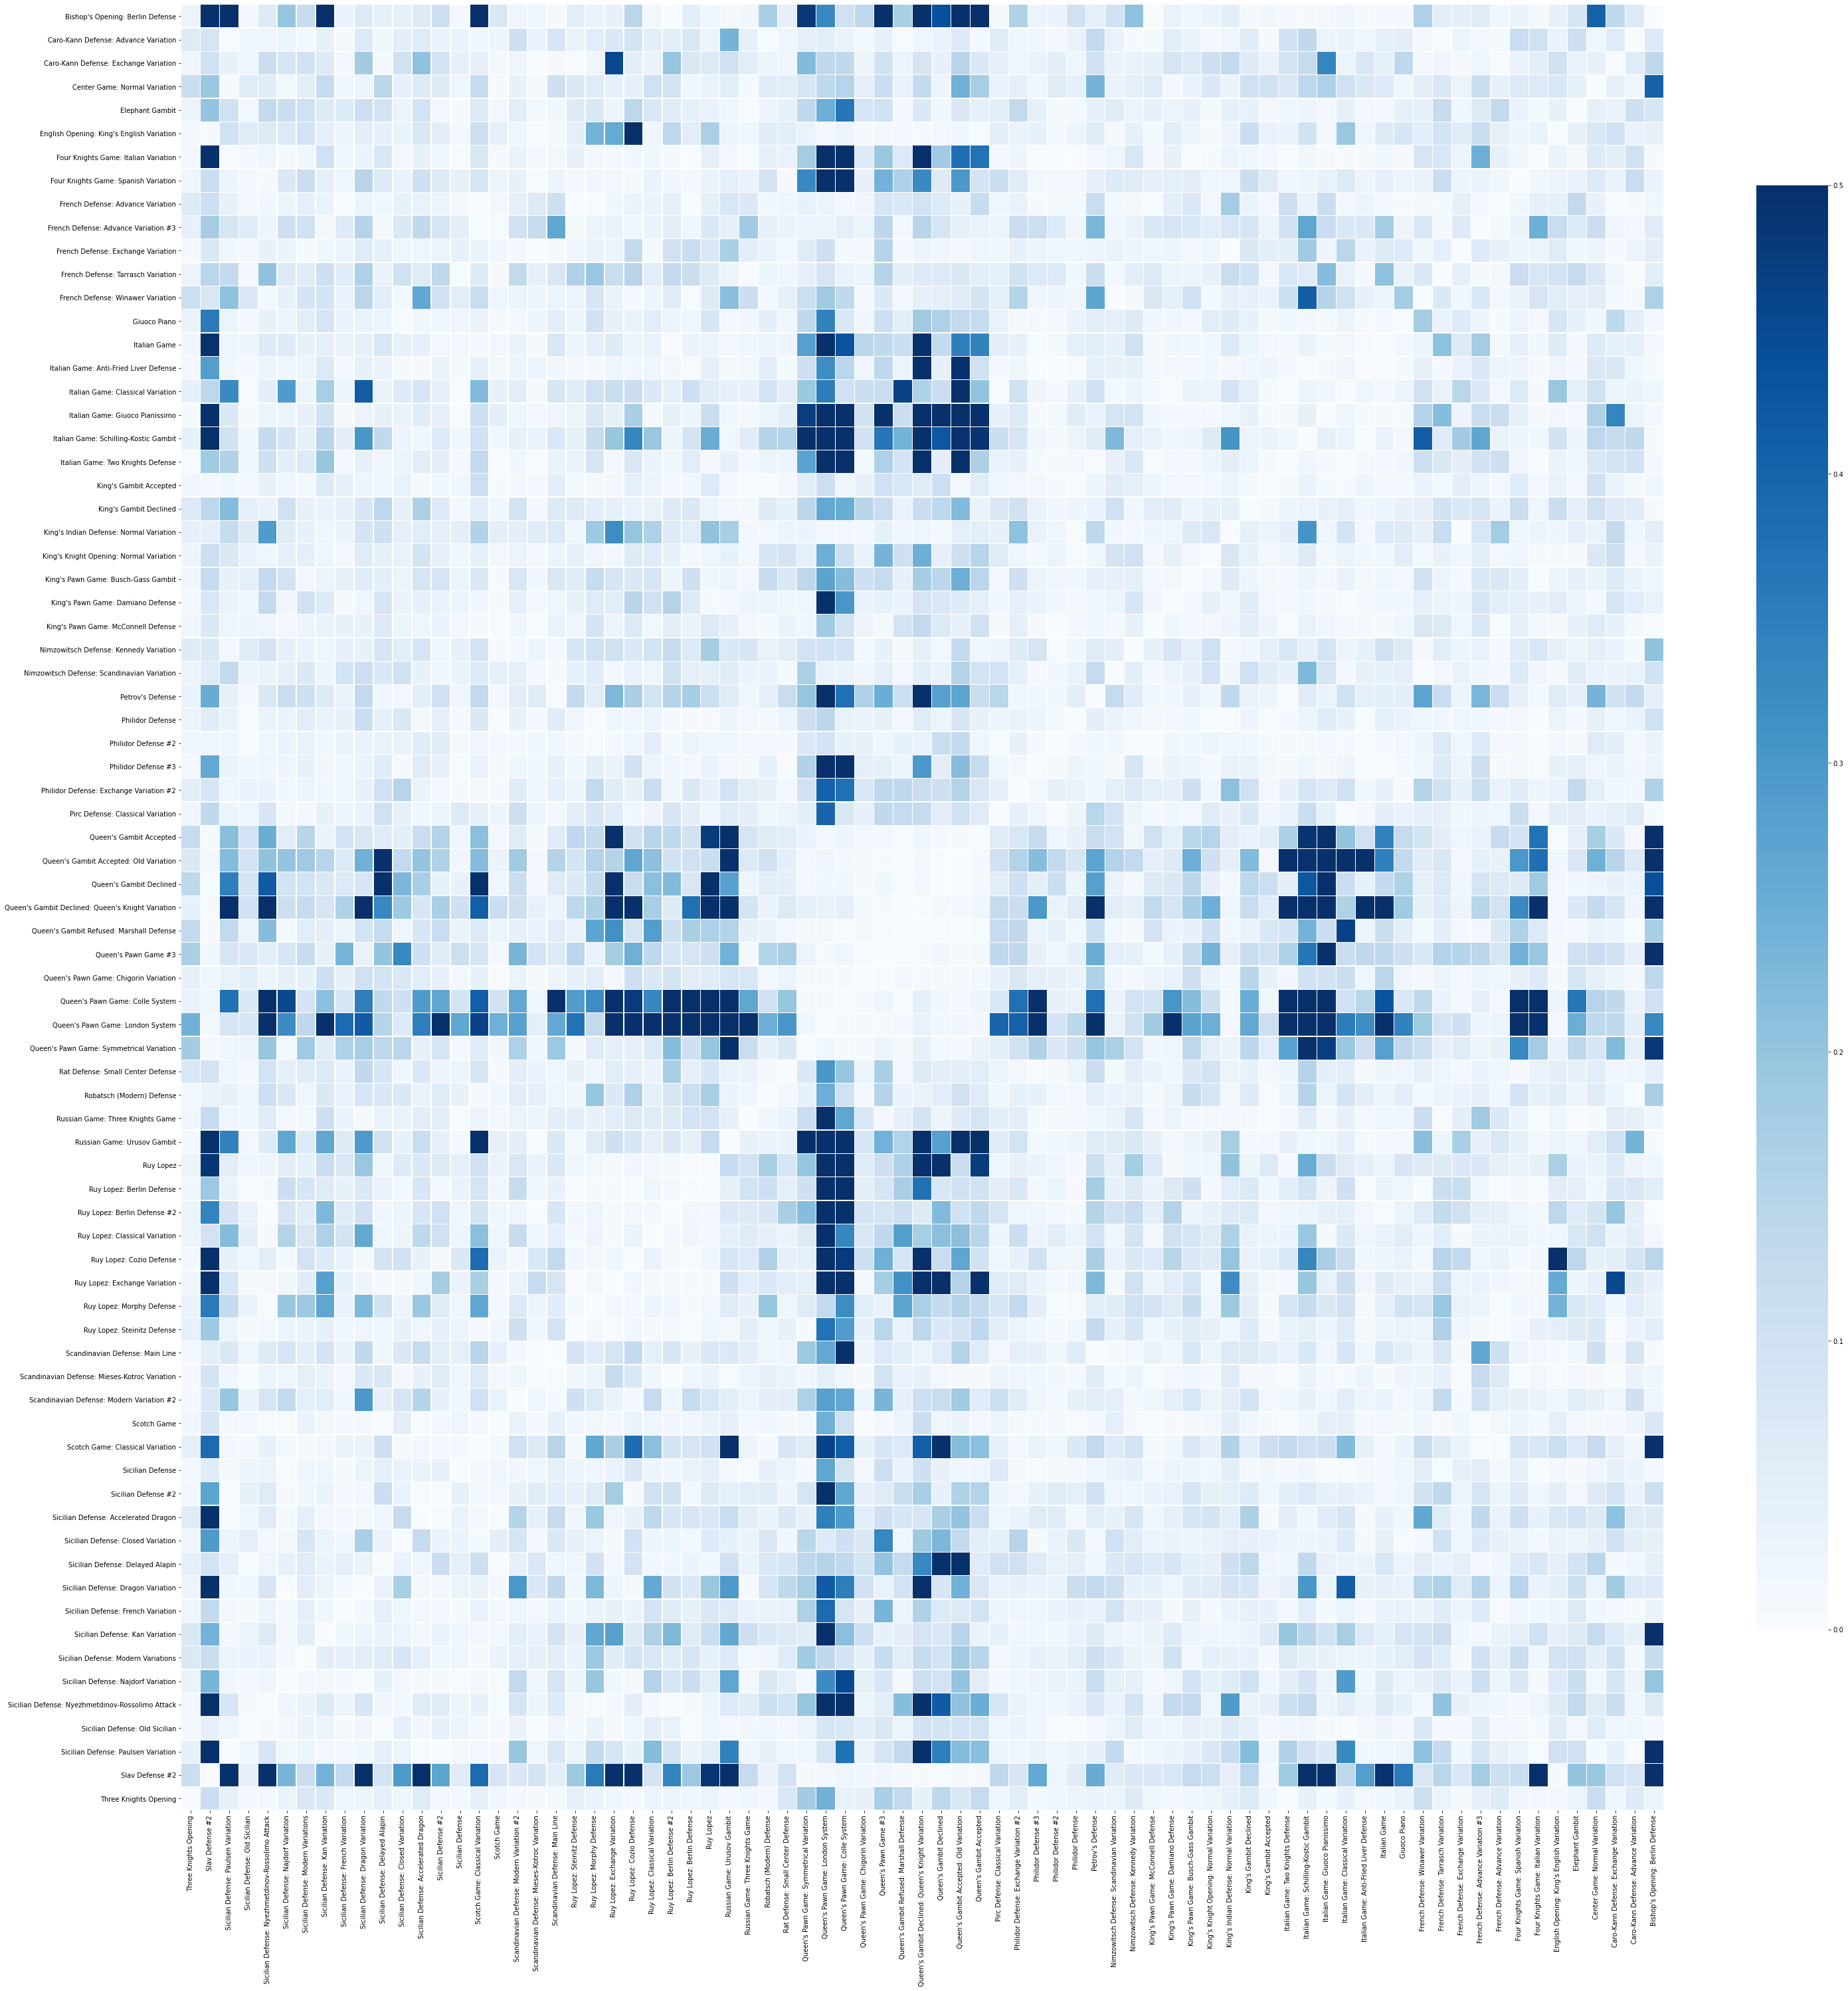

In [72]:
fig, ax = plt.subplots(figsize=(50, 50))

# plot heatmap
sb.heatmap(dfFinal, cmap="Blues", vmin= 0, vmax=0.5,
           linewidth=0.3, cbar_kws={"shrink": .8})
plt.show()

Hemos empezado el análisis de las aperturas creando el bagOfWords de los movimientos, este bagOfWords viene binarizado con números entre 0s y 1s así que la primera decisión que tomamos es no escalar los datos. Hemos usado el algoritmo de reducción de la dimensionalidad UMAP  “uniform mainfold approximation and projection”, que como bien explica el video complementario se dedica a reducir la dimensionalidad a dos dimensiones de forma muy eficiente, este algoritmo agrupa los puntos mediante las similiarity scores  y recalcula cada punto casi individualmente comparándolos mediante el spectral embedding lo que nos lleva a nuestra reducción de la dimensionalidad con la matriz embedding que podemos visualizar mediante el scatterplot.


Para agrupar en clusters los puntos del embedding, debido a la alta densidad y forma de nubes que presentan los puntos hemos pensado que un algoritmo de clasificación no supervisado particional basado en centroides como k-means sería la mejor opción, así obtenemos 5 supuestos clusters óptimos, comparando los diferentes valores de k visualmente con los colores del scatterplot podemos decir que los grupos parecen mejor distribuidos con 5 particiones. 


Analizando los histogramas, podemos ver que cada partición tiene más frecuencias de aperturas con nombre/descripciones similares, una para las Queens ambit y pawns, otra para las defensas, otra para las defensas avanzadas, otra para Ruy Lopez y la ultima par las aperturas italianas. Estaría muy bien calcular el porcentaje de cada apertura correspondiente a cada cluster.

Por último, en cuanto a la matriz de distancias y el heatmap, podemos apreciar que se forma un patrón en cruz en los datos, dejando el centro en blanco, lo que podríamos interpretar como 5 grupos de aperturas bien diferenciadas, coincidiendo con las particiones estimadas por el elbow test del k means.
